Getting Data from API


API has a limit of 1000 rows so using the offset to retrieve 1000 rows at a time

In [ ]:
!pip install requests pandas

In [ ]:
!pip install fancyimpute

In [ ]:
import requests
import pandas as pd
import time
from io import StringIO  # Import StringIO from io
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from fancyimpute import IterativeImputer


Downloading two datasets from API using offset to not

In [ ]:
# Base URLs for the APIs
base_url_1 = "https://data.austintexas.gov/resource/9t4d-g238.csv"
base_url_2 = "https://data.austintexas.gov/resource/wter-evkm.csv"

# Parameters for pagination
limit = 1000
offset = 0
all_data_1 = []
all_data_2 = []

# Function to get data with offset
def get_data(base_url, offset):
    params = {
        "$limit": limit,
        "$offset": offset
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        print(f"Data retrieved from {base_url} with offset: {offset}")
        return pd.read_csv(StringIO(response.text))
    else:
        print(f"Failed to retrieve data from {base_url} for offset: {offset}")
        return pd.DataFrame()

# Loop through the first dataset using pagination
while True:
    # Get data for the current offset for df1
    df1 = get_data(base_url_1, offset)

    # Break if no more data is returned
    if df1.empty:
        print("No more data to retrieve for df1.")
        break

    # Append the data to the list
    all_data_1.append(df1)

    # Get data for the current offset for df2
    df2 = get_data(base_url_2, offset)

    # Break if no more data is returned
    if df2.empty:
        print("No more data to retrieve for df2.")
        break

    # Append the data to the list
    all_data_2.append(df2)

    # Increment the offset for the next request
    offset += limit

    # Sleep to avoid hitting the API rate limit
    time.sleep(1)

# Combine all pages into a single DataFrame for each dataset
final_df1 = pd.concat(all_data_1, ignore_index=True)
final_df2 = pd.concat(all_data_2, ignore_index=True)

# Display the combined DataFrames
print(f"\nFinal DataFrame Shape for df1: {final_df1.shape}")
print(final_df1.head())

print(f"\nFinal DataFrame Shape for df2: {final_df2.shape}")
print(final_df2.head())


# **Data Dictionary for Austin Animal Center Outcomes Dataset**

| Column Name         | Description                                                  | API Field Name      | Data Type           |
|---------------------|--------------------------------------------------------------|---------------------|---------------------|
| **Animal ID**       | Unique identifier for each animal                            | `animal_id`         | Text                |
| **Name**            | Name of the animal (if available)                             | `name`              | Text                |
| **DateTime**        | Date and time of the outcome event                            | `datetime`          | Floating Timestamp  |
| **MonthYear**       | Month and year of the outcome event                           | `monthyear`         | Floating Timestamp  |
| **Date of Birth**   | Date of birth of the animal                                   | `date_of_birth`     | Floating Timestamp  |
| **Outcome Type**    | General category of outcome (e.g., Adoption, Transfer, Euthanasia) | `outcome_type` | Text                |
| **Outcome Subtype** | Specific subtype of outcome (e.g., Offsite, Foster)            | `outcome_subtype`   | Text                |
| **Animal Type**     | Type of animal (e.g., Dog, Cat)                               | `animal_type`       | Text                |
| **Sex upon Outcome**| Sex and reproductive status upon outcome (e.g., Neutered Male) | `sex_upon_outcome`  | Text                |
| **Age upon Outcome**| Age of the animal at the time of outcome                      | `age_upon_outcome`  | Text                |
| **Breed**           | Breed of the animal                                            | `breed`             | Text                |
| **Color**           | Color description of the animal                               | `color`             | Text                |

---

# **Data Dictionary for Intake Dataset**

| Column Name         | Description                                                  | API Field Name      | Data Type           |
|---------------------|--------------------------------------------------------------|---------------------|---------------------|
| **Animal ID**       | Unique identifier for each animal                            | `animal_id`         | Text                |
| **Name**            | Name of the animal (if available)                             | `name`              | Text                |
| **DateTime**        | Date and time of the intake event                            | `datetime`          | Floating Timestamp  |
| **MonthYear**       | Month and year of the intake event                           | `datetime2`         | Floating Timestamp  |
| **Found Location**  | Location where the animal was found                          | `found_location`    | Text                |
| **Intake Type**     | General intake category (e.g., Stray, Owner Surrender)       | `intake_type`       | Text                |
| **Intake Condition** | Condition of the animal at intake (e.g., Injured, Healthy) | `intake_condition`  | Text                |
| **Animal Type**     | Type of animal (e.g., Dog, Cat)                              | `animal_type`       | Text                |
| **Sex upon Intake** | Sex and reproductive status upon intake (e.g., Neutered Male) | `sex_upon_intake`  | Text                |
| **Age upon Intake** | Age of the animal at the time of intake                      | `age_upon_intake`  | Text                |
| **Breed**           | Breed of the animal                                          | `breed`             | Text                |
| **Color**           | Color description of the animal                              | `color`             | Text                |

In [ ]:
# Check for unique animal_id counts
unique_df1 = final_df1['animal_id'].nunique()
unique_df2 = final_df2['animal_id'].nunique()
print(f"Unique animal_id in df1: {unique_df1}")
print(f"Unique animal_id in df2: {unique_df2}")

# Check for duplicates in each dataset
duplicates_df1 = final_df1['animal_id'].duplicated().sum()
duplicates_df2 = final_df2['animal_id'].duplicated().sum()
print(f"Duplicate animal_id in df1: {duplicates_df1}")
print(f"Duplicate animal_id in df2: {duplicates_df2}")




Unique animal_id in df1: 154493
Unique animal_id in df2: 149283
Duplicate animal_id in df1: 17367
Duplicate animal_id in df2: 22448


Naming the dfs more identifiable names

In [ ]:
# Rename df1 and df2 for clarity
df_outcome = final_df1
df_intake = final_df2

print("\nDataFrames Renamed:")
print("Outcome DataFrame: df_outcome")
print("Intake DataFrame: df_intake")



DataFrames Renamed:
Outcome DataFrame: df_outcome
Intake DataFrame: df_intake


Keeping the latest intake and latest outcome for all unique animal IDs

There is not that much duplication so we still capture most of the data without having weird intake and output length of stays

In [ ]:
# Convert datetime columns to datetime format
df_intake['datetime'] = pd.to_datetime(df_intake['datetime'], errors='coerce')
df_outcome['datetime'] = pd.to_datetime(df_outcome['datetime'], errors='coerce')

# Keep the latest intake for each animal_id
latest_intake = df_intake.sort_values(by='datetime', ascending=False).drop_duplicates(subset='animal_id', keep='first')

# Keep the latest outcome for each animal_id
final_outcome = df_outcome.sort_values(by='datetime', ascending=False).drop_duplicates(subset='animal_id', keep='first')


Renaming the columns to be more identifiable

In [ ]:
# Rename outcome columns
final_outcome = final_outcome.rename(columns={
    'name': 'name_outcome',
    'datetime': 'datetime_outcome',
    'monthyear': 'monthyear_outcome',
    'date_of_birth': 'date_of_birth_outcome',
    'outcome_type': 'outcome_type',
    'outcome_subtype': 'outcome_subtype',
    'animal_type': 'animal_type_outcome',
    'sex_upon_outcome': 'sex_upon_outcome',
    'age_upon_outcome': 'age_upon_outcome',
    'breed': 'breed_outcome',
    'color': 'color_outcome'
})

# Rename intake columns
latest_intake = latest_intake.rename(columns={
    'name': 'name_intake',
    'datetime': 'datetime_intake',
    'found_location': 'found_location',
    'intake_type': 'intake_type',
    'intake_condition': 'intake_condition',
    'animal_type': 'animal_type_intake',
    'sex_upon_intake': 'sex_upon_intake',
    'age_upon_intake': 'age_upon_intake',
    'breed': 'breed_intake',
    'color': 'color_intake'
})



In [ ]:
latest_intake

,animal_id,name_intake,datetime_intake,datetime2,found_location,intake_type,intake_condition,animal_type_intake,sex_upon_intake,age_upon_intake,breed_intake,color_intake
171728,A925689,Yola,2025-02-27 16:39:00,2025-02-27T16:39:00.000,2017 Bluebonnet Ln in Austin (TX),Public Assist,Normal,Dog,Intact Female,2 years,Pit Bull/Labrador Retriever,White/Black
171727,A925690,Jade,2025-02-27 16:39:00,2025-02-27T16:39:00.000,2017 Bluebonnet Ln in Austin (TX),Public Assist,Normal,Dog,Intact Female,2 years,Rottweiler,Black/Brown
171696,A912256,Yarrow,2025-02-27 14:22:00,2025-02-27T14:22:00.000,3414 Hollywood Ave in Austin (TX),Owner Surrender,Behavior,Dog,Neutered Male,7 months,Labrador Retriever/Siberian Husky,Cream/White
171691,A925686,NaN,2025-02-27 14:20:00,2025-02-27T14:20:00.000,1144 Airport Boulevard in Austin (TX),Stray,Normal,Dog,Intact Female,3 years,Shih Tzu,Cream/Chocolate
171689,A925681,NaN,2025-02-27 14:16:00,2025-02-27T14:16:00.000,Dee Gabriel Collins Rd And Mckinney Falls Pkwy...,Stray,Normal,Dog,Unknown,2 years,Cairn Terrier Mix,Black/White
...,...,...,...,...,...,...,...,...,...,...,...,...
146372,A664233,Stevie,2013-10-01 08:53:00,2013-10-01T08:53:00.000,7405 Springtime in Austin (TX),Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White
2983,A664237,NaN,2013-10-01 08:33:00,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
144202,A664236,NaN,2013-10-01 08:33:00,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
48521,A664235,NaN,2013-10-01 08:33:00,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White


## Joining the two Datasets into one - Using inner to only keep matching rows

In [ ]:
# Perform Inner Join to get only animals with both latest intake and final outcome
animal_df = pd.merge(latest_intake, final_outcome, on='animal_id', how='inner')

# Display the shape and first few rows of the joined DataFrame
print(f"\nAnimal DataFrame Shape (Latest Intake and Final Outcome with Renamed Columns): {animal_df.shape}")
print(animal_df.head())



Animal DataFrame Shape (Latest Intake and Final Outcome with Renamed Columns): (148601, 23)
  animal_id name_intake     datetime_intake                datetime2  \
0   A912256      Yarrow 2025-02-27 14:22:00  2025-02-27T14:22:00.000   
1   A925674     Unknown 2025-02-27 13:46:00  2025-02-27T13:46:00.000   
2   A921540   *Pricilla 2025-02-27 13:46:00  2025-02-27T13:46:00.000   
3   A871344      Shotty 2025-02-27 13:40:00  2025-02-27T13:40:00.000   
4   A853027       Ellie 2025-02-27 13:04:00  2025-02-27T13:04:00.000   

                                      found_location      intake_type  \
0                  3414 Hollywood Ave in Austin (TX)  Owner Surrender   
1  Willam B Travis Building Floor 8 1701 Congress...         Wildlife   
2                                        Austin (TX)  Owner Surrender   
3                         1506 E 13Th in Austin (TX)    Public Assist   
4                                        Austin (TX)  Owner Surrender   

  intake_condition animal_type_inta

In [ ]:
pd.set_option("display.max_columns", None)

In [ ]:
animal_df

,animal_id,name_intake,datetime_intake,datetime2,found_location,intake_type,intake_condition,animal_type_intake,sex_upon_intake,age_upon_intake,breed_intake,color_intake,name_outcome,datetime_outcome,monthyear_outcome,date_of_birth_outcome,outcome_type,outcome_subtype,animal_type_outcome,sex_upon_outcome,age_upon_outcome,breed_outcome,color_outcome
0,A912256,Yarrow,2025-02-27 14:22:00,2025-02-27T14:22:00.000,3414 Hollywood Ave in Austin (TX),Owner Surrender,Behavior,Dog,Neutered Male,7 months,Labrador Retriever/Siberian Husky,Cream/White,Yarrow,2024-09-21 12:11:00,2024-09-21T12:11:00.000,2024-07-04T00:00:00.000,Return to Owner,NaN,Dog,Neutered Male,2 months,Labrador Retriever/Siberian Husky,Cream/White
1,A925674,Unknown,2025-02-27 13:46:00,2025-02-27T13:46:00.000,Willam B Travis Building Floor 8 1701 Congress...,Wildlife,Normal,Other,Unknown,2 years,Bat,Black,Unknown,2025-02-27 15:20:00,2025-02-27T15:20:00.000,2023-02-27T00:00:00.000,Euthanasia,Rabies Risk,Other,Unknown,NaN,Bat,Black
2,A921540,*Pricilla,2025-02-27 13:46:00,2025-02-27T13:46:00.000,Austin (TX),Owner Surrender,Normal,Dog,Spayed Female,3 months,Labrador Retriever Mix,White/Tan,*Pricilla,2025-02-05 16:17:00,2025-02-05T16:17:00.000,2024-11-26T00:00:00.000,Adoption,NaN,Dog,Spayed Female,2 months,Labrador Retriever Mix,White/Tan
3,A871344,Shotty,2025-02-27 13:40:00,2025-02-27T13:40:00.000,1506 E 13Th in Austin (TX),Public Assist,Unknown,Dog,Intact Male,3 years,Pit Bull Mix,Fawn/White,Shotty,2022-12-23 11:47:00,2022-12-23T11:47:00.000,2021-12-22T00:00:00.000,Return to Owner,NaN,Dog,Intact Male,1 year,Pit Bull Mix,Fawn/White
4,A853027,Ellie,2025-02-27 13:04:00,2025-02-27T13:04:00.000,Austin (TX),Owner Surrender,Sick,Dog,Spayed Female,5 years,Pit Bull/Great Dane,Brown Brindle/White,Ellie,2023-02-23 18:15:00,2023-02-23T18:15:00.000,2019-03-11T00:00:00.000,Adoption,NaN,Dog,Spayed Female,3 years,Pit Bull/Great Dane,Brown Brindle/White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148596,A664233,Stevie,2013-10-01 08:53:00,2013-10-01T08:53:00.000,7405 Springtime in Austin (TX),Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White,Stevie,2013-10-01 15:33:00,2013-10-01T15:33:00.000,2010-09-30T00:00:00.000,Euthanasia,Suffering,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White
148597,A664237,NaN,2013-10-01 08:33:00,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,NaN,2013-10-01 10:44:00,2013-10-01T10:44:00.000,2013-09-24T00:00:00.000,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
148598,A664236,NaN,2013-10-01 08:33:00,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,NaN,2013-10-01 10:44:00,2013-10-01T10:44:00.000,2013-09-24T00:00:00.000,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
148599,A664235,NaN,2013-10-01 08:33:00,2013-10-01T08:33:00.000,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White,NaN,2013-10-01 10:39:00,2013-10-01T10:39:00.000,2013-09-24T00:00:00.000,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White


In [ ]:
animal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148601 entries, 0 to 148600
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   animal_id              148601 non-null  object        
 1   name_intake            101705 non-null  object        
 2   datetime_intake        148601 non-null  datetime64[ns]
 3   datetime2              148601 non-null  object        
 4   found_location         148601 non-null  object        
 5   intake_type            148601 non-null  object        
 6   intake_condition       148601 non-null  object        
 7   animal_type_intake     148601 non-null  object        
 8   sex_upon_intake        148599 non-null  object        
 9   age_upon_intake        148600 non-null  object        
 10  breed_intake           148601 non-null  object        
 11  color_intake           148601 non-null  object        
 12  name_outcome           101705 non-null  obje

## Handling nulls


In [ ]:
# Check for null values and percentage of nulls for each column
null_counts = animal_df.isnull().sum()
null_percentages = (null_counts / len(animal_df)) * 100

null_info = pd.DataFrame({'Null Counts': null_counts, 'Null Percentage': null_percentages})
null_info


,Null Counts,Null Percentage
animal_id,0,0.000000
name_intake,46896,31.558334
datetime_intake,0,0.000000
datetime2,0,0.000000
found_location,0,0.000000
intake_type,0,0.000000
intake_condition,0,0.000000
animal_type_intake,0,0.000000
sex_upon_intake,2,0.001346
age_upon_intake,1,0.000673


More than 50% of values are missing in outcome_subtype best to drop this column

In [ ]:
animal_df.drop('outcome_subtype', axis=1, inplace=True)

Null names could mean something more than it just being null. To preseve this information, we will create a new feature called has_name which is a binary 0 1

In [ ]:
# Text Features from Name
animal_df['has_name'] = animal_df['name_intake'].notna().astype(int)

Dropping the name columns now that we have the feature

In [ ]:
animal_df.drop('name_intake', axis=1, inplace=True)
animal_df.drop('name_outcome', axis=1, inplace=True)

Checking Nulls again

In [ ]:
# Check for null values and percentage of nulls for each column
null_counts = animal_df.isnull().sum()
null_percentages = (null_counts / len(animal_df)) * 100

null_info = pd.DataFrame({'Null Counts': null_counts, 'Null Percentage': null_percentages})
null_info

,Null Counts,Null Percentage
animal_id,0,0.000000
datetime_intake,0,0.000000
datetime2,0,0.000000
found_location,0,0.000000
intake_type,0,0.000000
intake_condition,0,0.000000
animal_type_intake,0,0.000000
sex_upon_intake,2,0.001346
age_upon_intake,1,0.000673
breed_intake,0,0.000000


Too few nulls for imputation just dropping them

In [ ]:
# Drop rows with any null values
animal_df.dropna(inplace=True)

# Verify that there are no more nulls
null_counts = animal_df.isnull().sum()
null_percentages = (null_counts / len(animal_df)) * 100

null_info = pd.DataFrame({'Null Counts': null_counts, 'Null Percentage': null_percentages})
null_info


,Null Counts,Null Percentage
animal_id,0,0.0
datetime_intake,0,0.0
datetime2,0,0.0
found_location,0,0.0
intake_type,0,0.0
intake_condition,0,0.0
animal_type_intake,0,0.0
sex_upon_intake,0,0.0
age_upon_intake,0,0.0
breed_intake,0,0.0


##Imputation Pipeline Excluded for now

Excluding date related columns since we can't ever guess the correct value and animal_id

In [ ]:
# # List of Columns to Exclude from Imputation
# exclude_cols = [
#     'animal_id',
#     'datetime_intake',
#     'datetime_outcome',
#     'datetime2',
#     'monthyear_outcome',
#     'date_of_birth_outcome'
# ]

# # Columns to Impute (excluding excluded columns)
# impute_cols = [col for col in animal_df.columns if col not in exclude_cols]

# print("\nColumns to Impute (Excluding Non-Imputed Columns):", impute_cols)
# print("\nExcluded Columns:", exclude_cols)


In [ ]:
# # Numerical Column
# numerical_cols = ['has_name']

# # Categorical Columns (excluding excluded columns)
# categorical_cols = ['found_location',
#                     'intake_type', 'intake_condition',
#                     'animal_type_intake', 'sex_upon_intake',
#                     'age_upon_intake', 'breed_intake', 'color_intake',
#                     'outcome_type', 'animal_type_outcome',
#                     'sex_upon_outcome', 'age_upon_outcome',
#                     'breed_outcome', 'color_outcome']


In [ ]:
# # Numerical Imputation Pipeline using MICE
# numerical_pipeline = Pipeline(steps=[
#     ('mice_imputer', IterativeImputer(max_iter=10, random_state=42))
# ])


In [ ]:
# # Categorical Imputation Pipeline using Mode
# categorical_pipeline = Pipeline(steps=[
#     ('mode_imputer', SimpleImputer(strategy='most_frequent'))
# ])


In [ ]:
# # Combine Pipelines using ColumnTransformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_pipeline, numerical_cols),
#         ('cat', categorical_pipeline, categorical_cols)
#     ],
#     remainder='drop'  # Exclude non-imputed columns
# )


In [ ]:
# # Apply the imputation pipeline to the DataFrame (excluding non-imputed columns)
# imputed_values = preprocessor.fit_transform(animal_df[impute_cols])

# # Convert the imputed data back into a DataFrame with the same column names
# imputed_df = pd.DataFrame(imputed_values, columns=numerical_cols + categorical_cols, index=animal_df.index)

# # Preserve Non-Imputed Columns
# non_imputed_df = animal_df[exclude_cols]

# # Combine Imputed Data with Non-Imputed Columns
# animal_df = pd.concat([imputed_df, non_imputed_df], axis=1)

# # Ensure Correct Column Order
# animal_df = animal_df[sorted(animal_df.columns)]

# print("\nImputation Completed and Updated Directly in animal_df.")


In [ ]:
# # Check Shape Consistency
# print("\nDataFrame Shape After Imputation:", animal_df.shape)

# # Check for NaN values to confirm imputation
# missing_after_imputation = animal_df.isna().sum()
# print("\nMissing Values After Imputation (Final Check):")
# print(missing_after_imputation)


In [ ]:
# # Check for null values and percentage of nulls for each column
# null_counts = animal_df.isnull().sum()
# null_percentages = (null_counts / len(animal_df)) * 100

# null_info = pd.DataFrame({'Null Counts': null_counts, 'Null Percentage': null_percentages})
# null_info


## Feature Engineering

In [ ]:
animal_df["outcome_type"].value_counts()

,count
outcome_type,
Adoption,70151
Transfer,45439
Return to Owner,19280
Euthanasia,10274
Died,1582
Rto-Adopt,891
Disposal,832
Missing,74
Relocate,26


Too many different outcomes so lets group them into Positive Negative and Neutral

In [ ]:
# Grouping Outcome Types
def group_outcome(outcome):
    if outcome in ['Adoption', 'Return to Owner', 'Rto-Adopt']:
        return 'Positive'
    elif outcome in ['Transfer', 'Relocate']:
        return 'Neutral'
    elif outcome in ['Euthanasia', 'Died', 'Disposal', 'Lost', 'Missing', 'Stolen']:
        return 'Negative'
    else:
        return 'Other'

# Apply Grouping
animal_df['outcome_group'] = animal_df['outcome_type'].apply(group_outcome)


In [ ]:
animal_df['outcome_group'].value_counts()

,count
outcome_group,
Positive,90322
Neutral,45465
Negative,12767


Dropping the others if they exist

In [ ]:
animal_df = animal_df[animal_df['outcome_group'] != 'Other']


In [ ]:
animal_df['age_upon_outcome'].value_counts()

,count
age_upon_outcome,
1 year,24011
2 years,23240
2 months,20554
3 months,8198
3 years,7919
1 month,6695
4 months,5295
4 years,4630
5 years,4261


Inconsistent age values recalculating since we have approximate DOB

In [ ]:
# Convert relevant date columns to datetime format
date_cols = [
    'datetime_intake',
    'datetime_outcome',
    'date_of_birth_outcome'
]

for col in date_cols:
    animal_df[col] = pd.to_datetime(animal_df[col], errors='coerce')

print("\nDate Columns Converted to datetime64[ns].")



Date Columns Converted to datetime64[ns].


In [ ]:
# Calculate Age in Days
animal_df['age_days_intake'] = (animal_df['datetime_intake'] - animal_df['date_of_birth_outcome']).dt.days
animal_df['age_days_outcome'] = (animal_df['datetime_outcome'] - animal_df['date_of_birth_outcome']).dt.days

# Drop Negative or Zero Age Values (Invalid Data)
animal_df = animal_df[(animal_df['age_days_intake'] > 0) & (animal_df['age_days_outcome'] > 0)]

print("\nRecalculated Ages at Intake and Outcome (in Days).")



Recalculated Ages at Intake and Outcome (in Days).


In [ ]:
# Function to Classify Ages
def classify_age(days):
    if days < 365:
        return 'Puppy/Kitten'
    elif days < 1095:
        return 'Young Adult'
    elif days < 2555:
        return 'Adult'
    else:
        return 'Senior'

# Apply Classification to Intake and Outcome Ages
animal_df['age_group_intake'] = animal_df['age_days_intake'].apply(classify_age)
animal_df['age_group_outcome'] = animal_df['age_days_outcome'].apply(classify_age)

print("\nClassified Age Groups at Intake and Outcome.")



Classified Age Groups at Intake and Outcome.


Calculating LOS at shelter

In [ ]:
# Calculate Length of Stay (LOS) at Shelter in Days
animal_df['los_at_shelter'] = (animal_df['datetime_outcome'] - animal_df['datetime_intake']).dt.days

# Drop Negative or Zero LOS (Invalid Data)
animal_df = animal_df[animal_df['los_at_shelter'] > 0]

print("\nRecalculated Length of Stay (LOS) at Shelter (in Days).")



Recalculated Length of Stay (LOS) at Shelter (in Days).


In [ ]:
# Display Distribution of Recalculated Ages and LOS
print("\nDistribution of Recalculated Ages at Intake (Days):")
print(animal_df['age_days_intake'].describe())

print("\nDistribution of Recalculated Ages at Outcome (Days):")
print(animal_df['age_days_outcome'].describe())

print("\nDistribution of Recalculated LOS at Shelter (Days):")
print(animal_df['los_at_shelter'].describe())

print("\nAge Group Distribution at Intake:")
print(animal_df['age_group_intake'].value_counts())

print("\nAge Group Distribution at Outcome:")
print(animal_df['age_group_outcome'].value_counts())



Distribution of Recalculated Ages at Intake (Days):
count    118562.000000
mean        720.236585
std        1007.245056
min           1.000000
25%          71.000000
50%         365.000000
75%         731.000000
max        9132.000000
Name: age_days_intake, dtype: float64

Distribution of Recalculated Ages at Outcome (Days):
count    118562.000000
mean        747.066404
std        1012.412154
min           2.000000
25%          95.000000
50%         370.000000
75%         794.000000
max        9137.000000
Name: age_days_outcome, dtype: float64

Distribution of Recalculated LOS at Shelter (Days):
count    118562.000000
mean         26.451772
std          62.990213
min           1.000000
25%           4.000000
50%           8.000000
75%          28.000000
max        3529.000000
Name: los_at_shelter, dtype: float64

Age Group Distribution at Intake:
age_group_intake
Puppy/Kitten    55592
Young Adult     37774
Adult           16126
Senior           9070
Name: count, dtype: int64

Age Gro

Month of Outcome for seeing seasonal trends

In [ ]:
# Extract Month of Outcome from datetime_outcome
animal_df['month_of_outcome'] = animal_df['datetime_outcome'].dt.to_period('M').astype(str)

print("\nCreated month_of_outcome Column.")



Created month_of_outcome Column.


<ipython-input-416-a4549e6cec1a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  animal_df['month_of_outcome'] = animal_df['datetime_outcome'].dt.to_period('M').astype(str)


In [ ]:
# Convert to Month Name
animal_df['month_of_outcome'] = animal_df['datetime_outcome'].dt.strftime('%B')

print("\nUpdated month_of_outcome to Month Name.")



Updated month_of_outcome to Month Name.


In [ ]:
animal_df.head()

,animal_id,datetime_intake,datetime2,found_location,intake_type,intake_condition,animal_type_intake,sex_upon_intake,age_upon_intake,breed_intake,color_intake,datetime_outcome,monthyear_outcome,date_of_birth_outcome,outcome_type,animal_type_outcome,sex_upon_outcome,age_upon_outcome,breed_outcome,color_outcome,has_name,outcome_group,age_days_intake,age_days_outcome,age_group_intake,age_group_outcome,los_at_shelter,month_of_outcome
15,A925524,2025-02-25 14:55:00,2025-02-25T14:55:00.000,6917 Meador Ave in Austin (TX),Public Assist,Injured,Dog,Intact Male,2 years,Bull Terrier,Brown,2025-02-27 12:05:00,2025-02-27T12:05:00.000,2023-02-25,Return to Owner,Dog,Intact Male,2 years,Bull Terrier,Brown,0,Positive,731,733,Young Adult,Young Adult,1,February
20,A925504,2025-02-25 12:29:00,2025-02-25T12:29:00.000,W Slaughter Ln And Menchaca Rd in Austin (TX),Stray,Normal,Dog,Intact Female,2 years,Rottweiler Mix,Black/Brown,2025-02-27 11:00:00,2025-02-27T11:00:00.000,2022-08-26,Transfer,Dog,Intact Female,2 years,Rottweiler Mix,Black/Brown,1,Neutral,914,916,Young Adult,Young Adult,1,February
22,A915768,2025-02-25 11:35:00,2025-02-25T11:35:00.000,Austin (TX),Stray,Normal,Cat,Neutered Male,5 months,Domestic Shorthair,Orange Tabby,2025-02-27 15:24:00,2025-02-27T15:24:00.000,2024-09-04,Adoption,Cat,Neutered Male,5 months,Domestic Shorthair,Orange Tabby,1,Positive,174,176,Puppy/Kitten,Puppy/Kitten,2,February
31,A925428,2025-02-24 13:15:00,2025-02-24T13:15:00.000,1901 W William Cannon Dr in Austin (TX),Wildlife,Normal,Other,Unknown,2 years,Bat,Brown,2025-02-25 19:00:00,2025-02-25T19:00:00.000,2023-02-24,Euthanasia,Other,Unknown,2 years,Bat,Brown,0,Negative,731,732,Young Adult,Young Adult,1,February
32,A925441,2025-02-24 13:11:00,2025-02-24T13:11:00.000,Austin (TX),Owner Surrender,Normal,Cat,Neutered Male,1 year,Domestic Shorthair,Brown Tabby,2025-02-25 16:33:00,2025-02-25T16:33:00.000,2024-02-24,Adoption,Cat,Neutered Male,1 year,Domestic Shorthair,Brown Tabby,1,Positive,366,367,Young Adult,Young Adult,1,February


In [ ]:
animal_df['los_at_shelter'].value_counts()

,count
los_at_shelter,
4,13503
3,8673
1,8589
5,8216
6,6425
...,...
444,1
1547,1
891,1


In [ ]:
animal_df['sex_upon_outcome'].value_counts()

,count
sex_upon_outcome,
Neutered Male,45797
Spayed Female,42923
Intact Female,13190
Intact Male,12737
Unknown,3915


Simplyfying the reproductive status

In [ ]:
def simplify_sex(sex):
    if sex in ['Neutered Male', 'Spayed Female']:
        return 'Fixed'
    elif sex in ['Intact Male', 'Intact Female']:
        return 'Intact'
    else:
        return 'Unknown'

# Apply Simplification
animal_df['reproductive_status'] = animal_df['sex_upon_outcome'].apply(simplify_sex)


Assuming worst case and when it is Unkown it is assumed the the animal is not fixed

In [ ]:
# Convert to Binary Column
animal_df['is_fixed'] = animal_df['reproductive_status'].apply(lambda x: 1 if x == 'Fixed' else 0)


In [ ]:
animal_df['breed_intake'].value_counts()

,count
breed_intake,
Domestic Shorthair Mix,23134
Domestic Shorthair,17781
Pit Bull Mix,6458
Labrador Retriever Mix,5974
Chihuahua Shorthair Mix,5028
...,...
Australian Shepherd/Brittany,1
Whippet/Miniature Pinscher,1
Border Collie/Doberman Pinsch,1


Checking if all rows have the same breed from the two tables

In [ ]:
count = len(animal_df[animal_df['breed_intake'] != animal_df['breed_outcome']])
print(f"Number of rows where breed intake differs from breed outcome: {count}")


Number of rows where breed intake differs from breed outcome: 0


Too many breed types segregating them by mix or pure

In [ ]:
# Identify Mix vs Pure
animal_df['breed_type'] = animal_df['breed_intake'].apply(lambda x: 'Mix' if 'Mix' in x else 'Pure')


Checking if all rows have same color from two tables

In [ ]:
count = len(animal_df[animal_df['color_intake'] != animal_df['color_outcome']])
print(f"Number of rows where color intake differs from color outcome: {count}")


Number of rows where color intake differs from color outcome: 0


In [ ]:
animal_df['color_intake'].value_counts()

,count
color_intake,
Black/White,12457
Black,10019
Brown Tabby,7619
White,4130
Brown Tabby/White,3986
...,...
Brown/Blue Merle,1
Cream Tabby/Cream Tabby,1
Tortie/Blue Tabby,1


Too many colors trying to simplify

In [ ]:
def simplify_color(color):
    """
    Simplify the color into broader categories
    """
    color = color.lower()

    # Black Group
    if any(word in color for word in ['black', 'ebony', 'charcoal']):
        return 'Black'

    # White Group
    elif any(word in color for word in ['white', 'cream', 'ivory', 'pearl', 'platinum']):
        return 'White'

    # Brown Group
    elif any(word in color for word in ['brown', 'brindle', 'chocolate', 'mocha', 'mahogany']):
        return 'Brown'

    # Grey Group
    elif any(word in color for word in ['gray', 'grey', 'blue', 'silver', 'slate', 'pewter', 'ash']):
        return 'Grey'

    # Gold Group
    elif any(word in color for word in ['gold', 'tan', 'yellow', 'fawn', 'buff', 'sandy']):
        return 'Gold'

    # Red Group
    elif any(word in color for word in ['red', 'ginger', 'orange', 'copper', 'auburn']):
        return 'Red'

    # Cream Group
    elif any(word in color for word in ['cream', 'beige', 'off-white']):
        return 'Cream'

    # Tabby Pattern
    elif 'tabby' in color:
        return 'Tabby'

    # Merle Pattern
    elif 'merle' in color:
        return 'Merle'

    # Tricolor Pattern
    elif 'tricolor' in color or ('black' in color and 'tan' in color and 'white' in color):
        return 'Tricolor'

    # Spotted or Speckled Patterns
    elif any(word in color for word in ['spotted', 'speckled', 'ticked', 'roan', 'freckled']):
        return 'Spotted'

    # Mixed or Multiple Colors
    elif '/' in color or 'and' in color:
        return 'Multicolor'

    # Default to Other
    else:
        return 'Other'


In [ ]:
# Apply Enhanced Color Grouping
animal_df['color_group'] = animal_df['color_intake'].apply(simplify_color)


In [ ]:
animal_df['color_group'].value_counts()

,count
color_group,
White,39248
Black,37419
Brown,14522
Other,8600
Grey,6211
Red,5154
Gold,4800
Tricolor,2590
Multicolor,18


In [ ]:
animal_df['intake_type'].value_counts()

,count
intake_type,
Stray,81555
Owner Surrender,26827
Public Assist,7314
Abandoned,1423
Wildlife,1382
Euthanasia Request,61


In [ ]:
animal_df['intake_condition'].value_counts()

,count
intake_condition,
Normal,104213
Injured,6641
Sick,3950
Nursing,1770
Neonatal,655
Medical,405
Aged,299
Other,252
Feral,116


Too many grouping them together

In [ ]:
# Intuitive Grouping Function for intake_condition
def group_intake_condition(condition):
    condition = condition.lower()

    # Healthy
    if condition in ['normal']:
        return 'Healthy/Normal'

    # Injured
    elif condition in ['injured', 'neurologic', 'med attn', 'med urgent']:
        return 'Injured'

    # Sick or Medical
    elif condition in ['sick', 'medical', 'parvo', 'panleuk', 'congenital']:
        return 'Sick/Medical'

    # Behavioral Issues
    elif condition in ['behavior', 'feral']:
        return 'Behavioral Issues'

    # Life Stage or Developmental
    elif condition in ['neonatal', 'nursing', 'aged', 'pregnant']:
        return 'Life Stage/Developmental'

    # Other or Unknown
    else:
        return 'Other/Unknown'


In [ ]:
# Apply Intuitive Grouping to intake_condition
animal_df['intake_condition_group'] = animal_df['intake_condition'].apply(group_intake_condition)

print("\nIntuitive Grouping Applied to intake_condition.")



Intuitive Grouping Applied to intake_condition.


In [ ]:
# Verify the new grouping
print("\nDistribution of intake_condition_group:")
print(animal_df['intake_condition_group'].value_counts())



Distribution of intake_condition_group:
intake_condition_group
Healthy/Normal              104213
Injured                       6703
Sick/Medical                  4358
Life Stage/Developmental      2831
Other/Unknown                  279
Behavioral Issues              178
Name: count, dtype: int64


In [ ]:
animal_df.head()

,animal_id,datetime_intake,datetime2,found_location,intake_type,intake_condition,animal_type_intake,sex_upon_intake,age_upon_intake,breed_intake,color_intake,datetime_outcome,monthyear_outcome,date_of_birth_outcome,outcome_type,animal_type_outcome,sex_upon_outcome,age_upon_outcome,breed_outcome,color_outcome,has_name,outcome_group,age_days_intake,age_days_outcome,age_group_intake,age_group_outcome,los_at_shelter,month_of_outcome,reproductive_status,is_fixed,breed_type,color_group,intake_condition_group
15,A925524,2025-02-25 14:55:00,2025-02-25T14:55:00.000,6917 Meador Ave in Austin (TX),Public Assist,Injured,Dog,Intact Male,2 years,Bull Terrier,Brown,2025-02-27 12:05:00,2025-02-27T12:05:00.000,2023-02-25,Return to Owner,Dog,Intact Male,2 years,Bull Terrier,Brown,0,Positive,731,733,Young Adult,Young Adult,1,February,Intact,0,Pure,Brown,Injured
20,A925504,2025-02-25 12:29:00,2025-02-25T12:29:00.000,W Slaughter Ln And Menchaca Rd in Austin (TX),Stray,Normal,Dog,Intact Female,2 years,Rottweiler Mix,Black/Brown,2025-02-27 11:00:00,2025-02-27T11:00:00.000,2022-08-26,Transfer,Dog,Intact Female,2 years,Rottweiler Mix,Black/Brown,1,Neutral,914,916,Young Adult,Young Adult,1,February,Intact,0,Mix,Black,Healthy/Normal
22,A915768,2025-02-25 11:35:00,2025-02-25T11:35:00.000,Austin (TX),Stray,Normal,Cat,Neutered Male,5 months,Domestic Shorthair,Orange Tabby,2025-02-27 15:24:00,2025-02-27T15:24:00.000,2024-09-04,Adoption,Cat,Neutered Male,5 months,Domestic Shorthair,Orange Tabby,1,Positive,174,176,Puppy/Kitten,Puppy/Kitten,2,February,Fixed,1,Pure,Red,Healthy/Normal
31,A925428,2025-02-24 13:15:00,2025-02-24T13:15:00.000,1901 W William Cannon Dr in Austin (TX),Wildlife,Normal,Other,Unknown,2 years,Bat,Brown,2025-02-25 19:00:00,2025-02-25T19:00:00.000,2023-02-24,Euthanasia,Other,Unknown,2 years,Bat,Brown,0,Negative,731,732,Young Adult,Young Adult,1,February,Unknown,0,Pure,Brown,Healthy/Normal
32,A925441,2025-02-24 13:11:00,2025-02-24T13:11:00.000,Austin (TX),Owner Surrender,Normal,Cat,Neutered Male,1 year,Domestic Shorthair,Brown Tabby,2025-02-25 16:33:00,2025-02-25T16:33:00.000,2024-02-24,Adoption,Cat,Neutered Male,1 year,Domestic Shorthair,Brown Tabby,1,Positive,366,367,Young Adult,Young Adult,1,February,Fixed,1,Pure,Brown,Healthy/Normal


In [ ]:
# Count where animal_type_intake and animal_type_outcome are different
count_different_animal_types = len(animal_df[animal_df['animal_type_intake'] != animal_df['animal_type_outcome']])
print(f"Number of rows where animal_type_intake differs from animal_type_outcome: {count_different_animal_types}")


Number of rows where animal_type_intake differs from animal_type_outcome: 0


In [ ]:
# Rename animal_type_intake to animal_type
animal_df.rename(columns={'animal_type_intake': 'animal_type'}, inplace=True)

# Drop animal_type_outcome
drop_cols = ['animal_type_outcome']

# Drop the column from animal_df
animal_df.drop(columns=drop_cols, inplace=True)

print("\nRenamed animal_type_intake to animal_type and Dropped animal_type_outcome.")



Renamed animal_type_intake to animal_type and Dropped animal_type_outcome.


Dropping irrelevant columns

Why These Columns Were Dropped

| Column Name             | Reason for Dropping                                  |
|--------------------------|------------------------------------------------------|
| `animal_id`              | Identifier, no predictive value                       |
| `datetime_intake`        | Detailed timestamp, replaced by `los_at_shelter`      |
| `datetime_outcome`       | Detailed timestamp, replaced by `month_of_outcome`    |
| `datetime2`              | Duplicate timestamp, no additional information        |
| `found_location`         | Highly variable, no predictive power                  |
| `intake_type`            | Not relevant after grouping `intake_condition`         |
| `intake_condition`       | Replaced by `intake_condition_group`                  |
| `breed_intake`           | Replaced by `breed_type`                             |
| `breed_outcome`          | Replaced by `breed_type`                             |
| `color_intake`           | Replaced by `color_group`                            |
| `color_outcome`          | Replaced by `color_group`                            |
| `monthyear_outcome`      | Replaced by `month_of_outcome`                       |
| `date_of_birth_outcome`  | No longer needed after recalculating ages             |
| `outcome_type`           | Replaced by `outcome_group`                          |
| `animal_type_outcome`    | Redundant after keeping `animal_type`                 |
| `sex_upon_intake`        | Replaced by `reproductive_status` and `is_fixed`      |
| `sex_upon_outcome`       | Replaced by `reproductive_status` and `is_fixed`      |
| `age_upon_intake`        | Replaced by `age_days_intake` and `age_group_intake`  |
| `age_upon_outcome`       | Replaced by `age_days_outcome` and `age_group_outcome`|
| `reproductive_status`       | Replaced by `is_fixed` |
| `age_group_outcome`       | Is redundant because of  `age_group_intake` and we want to know how the age near the outcome impacted it |



In [ ]:
# Final List of Columns to Drop
final_drop_cols = [
    'animal_id',
    'datetime_intake',
    'datetime_outcome',
    'datetime2',
    'found_location',
    'intake_type',
    'intake_condition',
    'breed_intake',
    'color_intake',
    'monthyear_outcome',
    'date_of_birth_outcome',
    'outcome_type',
    'sex_upon_intake',
    'sex_upon_outcome',
    'age_upon_intake',
    'age_upon_outcome',
    'breed_outcome',
    'color_outcome',
    'reproductive_status',
    'age_group_outcome'
]

print("\nFinal Columns to Drop:", final_drop_cols)



Final Columns to Drop: ['animal_id', 'datetime_intake', 'datetime_outcome', 'datetime2', 'found_location', 'intake_type', 'intake_condition', 'breed_intake', 'color_intake', 'monthyear_outcome', 'date_of_birth_outcome', 'outcome_type', 'sex_upon_intake', 'sex_upon_outcome', 'age_upon_intake', 'age_upon_outcome', 'breed_outcome', 'color_outcome', 'reproductive_status', 'age_group_outcome']


In [ ]:
# Drop the redundant columns from animal_df
animal_df.drop(columns=final_drop_cols, inplace=True)

print("\nDropped All Redundant Columns.")



Dropped All Redundant Columns.


                  has_name  age_days_intake  age_days_outcome  los_at_shelter  \
has_name          1.000000         0.176937          0.184579        0.137335   
age_days_intake   0.176937         1.000000          0.998065        0.050597   
age_days_outcome  0.184579         0.998065          1.000000        0.112589   
los_at_shelter    0.137335         0.050597          0.112589        1.000000   
is_fixed          0.285095         0.081903          0.091012        0.153943   

                  is_fixed  
has_name          0.285095  
age_days_intake   0.081903  
age_days_outcome  0.091012  
los_at_shelter    0.153943  
is_fixed          1.000000  


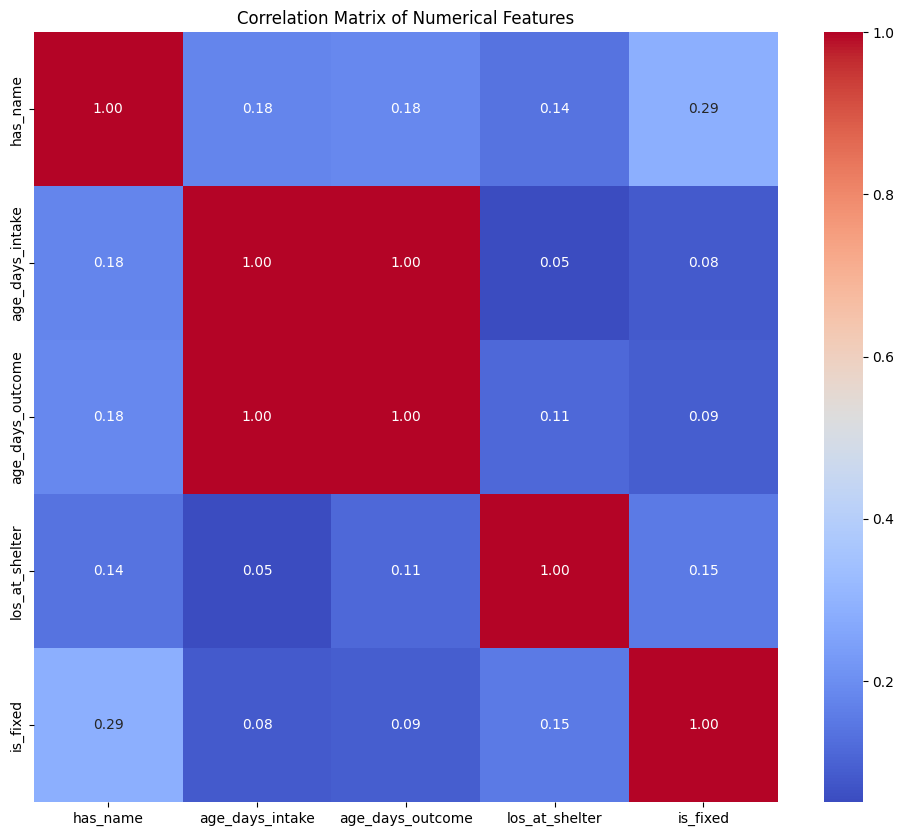

In [ ]:
# Select numerical columns for correlation analysis
numerical_cols = animal_df.select_dtypes(include=np.number).columns.tolist()

# Calculate the correlation matrix
correlation_matrix = animal_df[numerical_cols].corr()

# Display the correlation matrix
print(correlation_matrix)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Dropping due to high correlation

In [ ]:
# Drop 'age_days_intake'
animal_df.drop(columns=['age_days_intake'], inplace=True)


                  has_name  age_days_outcome  los_at_shelter  is_fixed
has_name          1.000000          0.184579        0.137335  0.285095
age_days_outcome  0.184579          1.000000        0.112589  0.091012
los_at_shelter    0.137335          0.112589        1.000000  0.153943
is_fixed          0.285095          0.091012        0.153943  1.000000


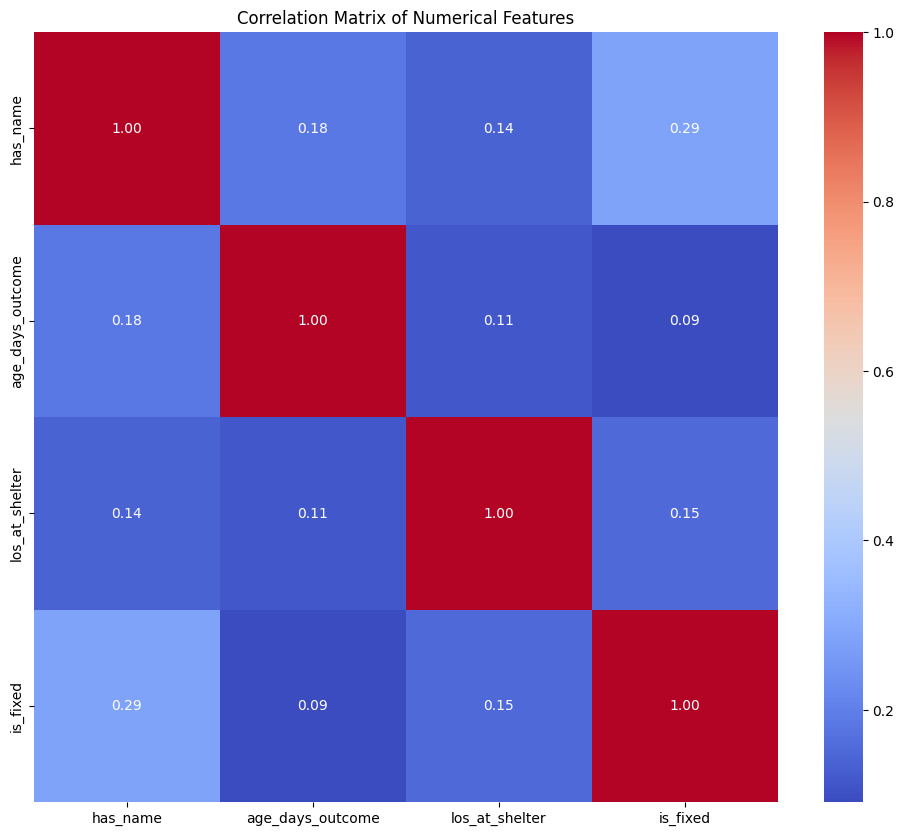

In [ ]:
# Select numerical columns for correlation analysis
numerical_cols = animal_df.select_dtypes(include=np.number).columns.tolist()

# Calculate the correlation matrix
correlation_matrix = animal_df[numerical_cols].corr()

# Display the correlation matrix
print(correlation_matrix)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [ ]:
animal_df.head()

,animal_type,has_name,outcome_group,age_days_outcome,age_group_intake,los_at_shelter,month_of_outcome,is_fixed,breed_type,color_group,intake_condition_group
15,Dog,0,Positive,733,Young Adult,1,February,0,Pure,Brown,Injured
20,Dog,1,Neutral,916,Young Adult,1,February,0,Mix,Black,Healthy/Normal
22,Cat,1,Positive,176,Puppy/Kitten,2,February,1,Pure,Red,Healthy/Normal
31,Other,0,Negative,732,Young Adult,1,February,0,Pure,Brown,Healthy/Normal
32,Cat,1,Positive,367,Young Adult,1,February,1,Pure,Brown,Healthy/Normal


In [ ]:
# prompt: save df to csv

animal_df.to_csv('animal_df.csv', index=False)


## Exploratory Data Analysis

Univariate Analysis

<ipython-input-7-04ca02cef514>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="outcome_group", data=animal_df, palette=custom_palette)


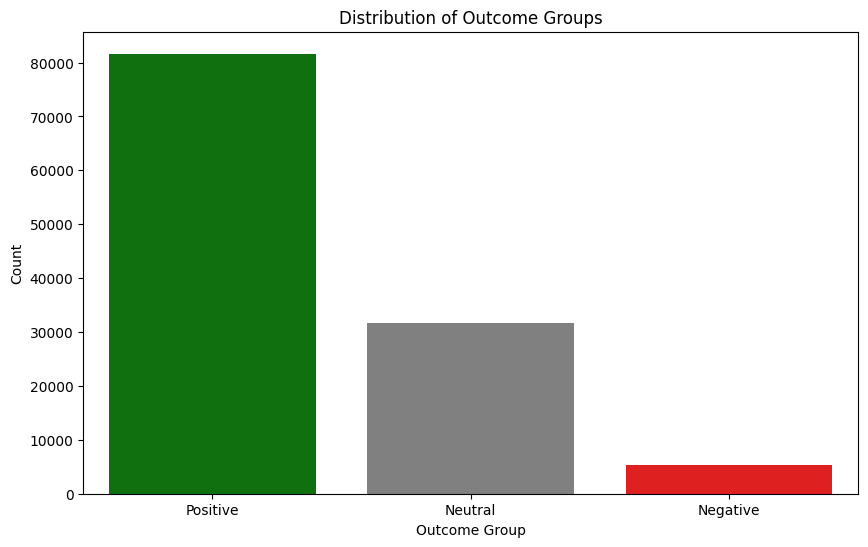

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom color mapping
custom_palette = {"Positive": "green", "Negative": "red", "Neutral": "gray"}

# Create the count plot with custom colors
plt.figure(figsize=(10, 6))
sns.countplot(x="outcome_group", data=animal_df, palette=custom_palette)

# Add labels and title
plt.title("Distribution of Outcome Groups")
plt.xlabel("Outcome Group")
plt.ylabel("Count")

# Show the plot
plt.show()


<ipython-input-8-250ce2e8015a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='animal_type', data=animal_df, palette='Set3')


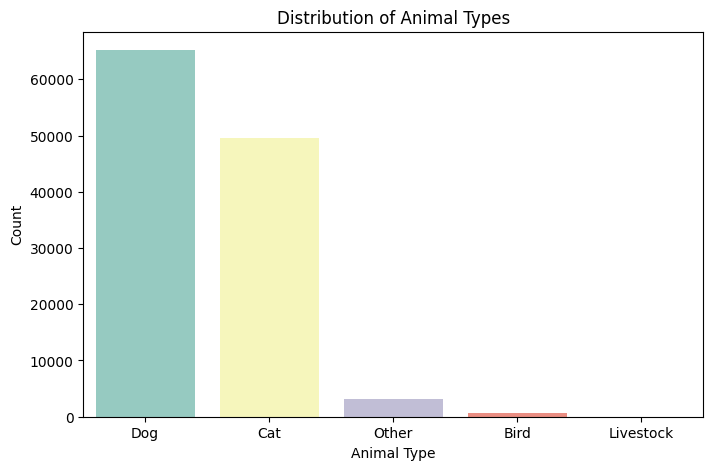

In [8]:
plt.figure(figsize=(8, 5))
sns.countplot(x='animal_type', data=animal_df, palette='Set3')
plt.title('Distribution of Animal Types')
plt.xlabel('Animal Type')
plt.ylabel('Count')
plt.show()


<ipython-input-11-a18eae6eae0e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='age_group_intake', data=animal_df, palette='Set1')


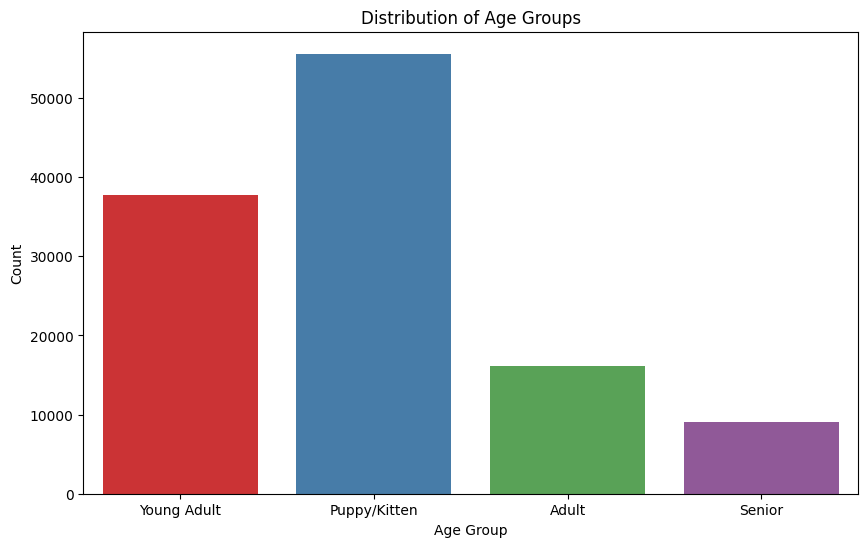

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(x='age_group_intake', data=animal_df, palette='Set1')
plt.title('Distribution of Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()


<ipython-input-13-89f776434041>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='breed_type', data=animal_df, palette='Set2')


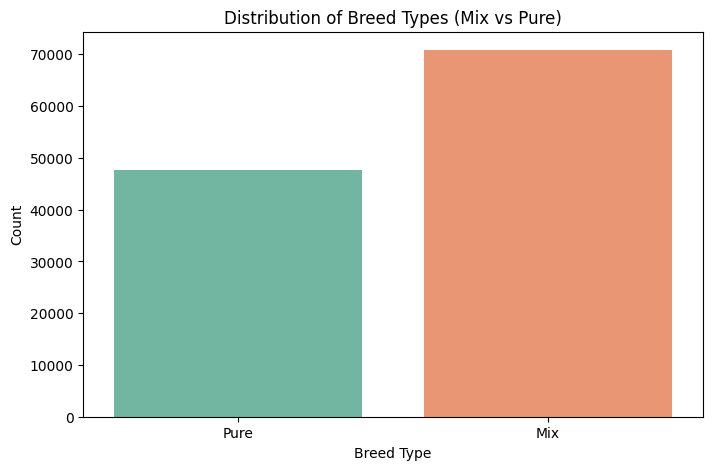

In [13]:
plt.figure(figsize=(8, 5))
sns.countplot(x='breed_type', data=animal_df, palette='Set2')
plt.title('Distribution of Breed Types (Mix vs Pure)')
plt.xlabel('Breed Type')
plt.ylabel('Count')
plt.show()


<ipython-input-16-37ad856ca14f>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='color_group', data=animal_df, palette=custom_palette, edgecolor="black")  # Add black borders for white bars


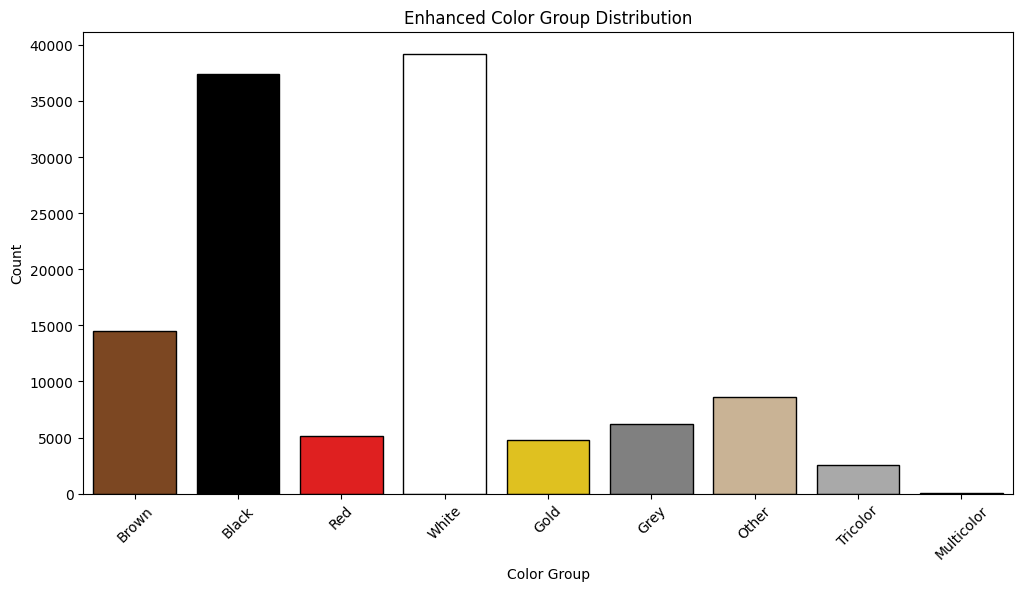

In [16]:
# Define a custom color palette matching the actual colors
custom_palette = {
    "Brown": "#8B4513",  # SaddleBrown
    "Black": "black",
    "Red": "red",
    "White": "white",
    "Gold": "#FFD700",  # Gold
    "Grey": "grey",
    "Other": "#D2B48C",  # Tan/Beige
    "Tricolor": "#A9A9A9",  # DarkGray
    "Multicolor": "#C0C0C0"  # Silver
}

# Create the count plot with custom colors
plt.figure(figsize=(12, 6))
sns.countplot(x='color_group', data=animal_df, palette=custom_palette, edgecolor="black")  # Add black borders for white bars

# Customize plot appearance
plt.title('Enhanced Color Group Distribution')
plt.xlabel("Color Group")  # ✅ Fix the x-axis title
plt.ylabel("Count")  # (Optional) Ensure the y-axis title is clear
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the plot
plt.show()



Bivariate Analysis

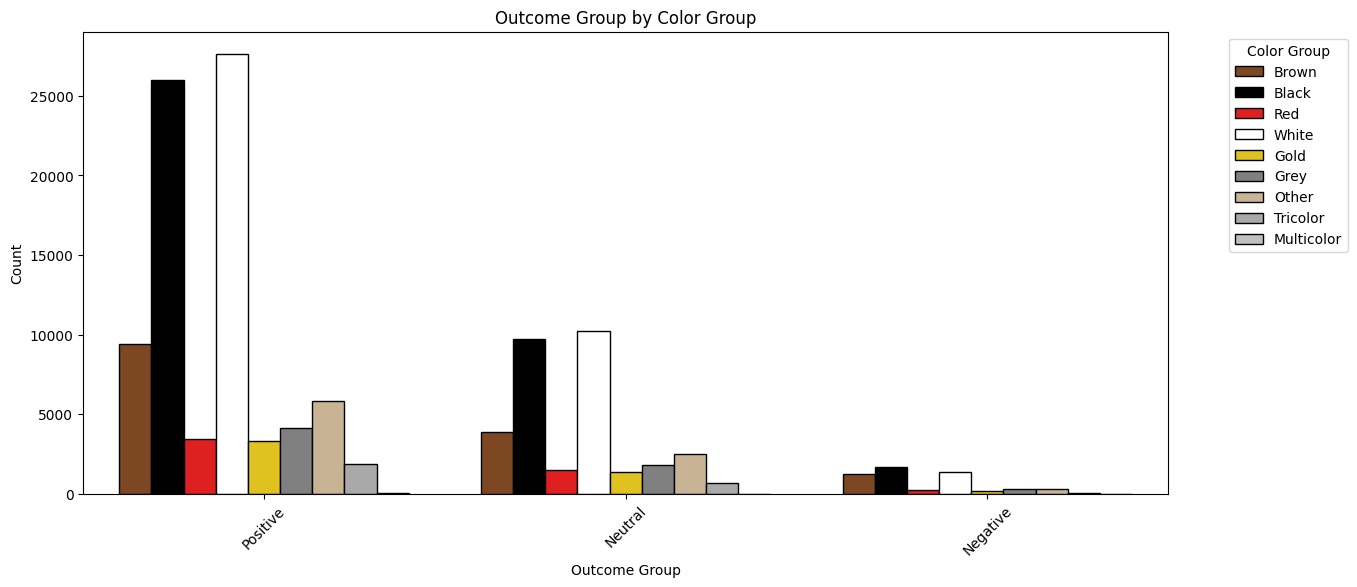

In [18]:
# Define a custom palette to match color names to actual colors
custom_palette = {
    "Brown": "#8B4513",  # SaddleBrown
    "Black": "black",
    "Red": "red",
    "White": "white",
    "Gold": "#FFD700",  # Gold
    "Grey": "grey",
    "Other": "#D2B48C",  # Tan/Beige
    "Tricolor": "#A9A9A9",  # DarkGray
    "Multicolor": "#C0C0C0"  # Silver
}

# Create the count plot with the custom color palette
plt.figure(figsize=(14, 6))
sns.countplot(x='outcome_group', hue='color_group', data=animal_df, palette=custom_palette, edgecolor="black")

# Customize plot appearance
plt.title('Outcome Group by Color Group')
plt.xlabel('Outcome Group')
plt.ylabel('Count')
plt.legend(title='Color Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Show the plot
plt.show()



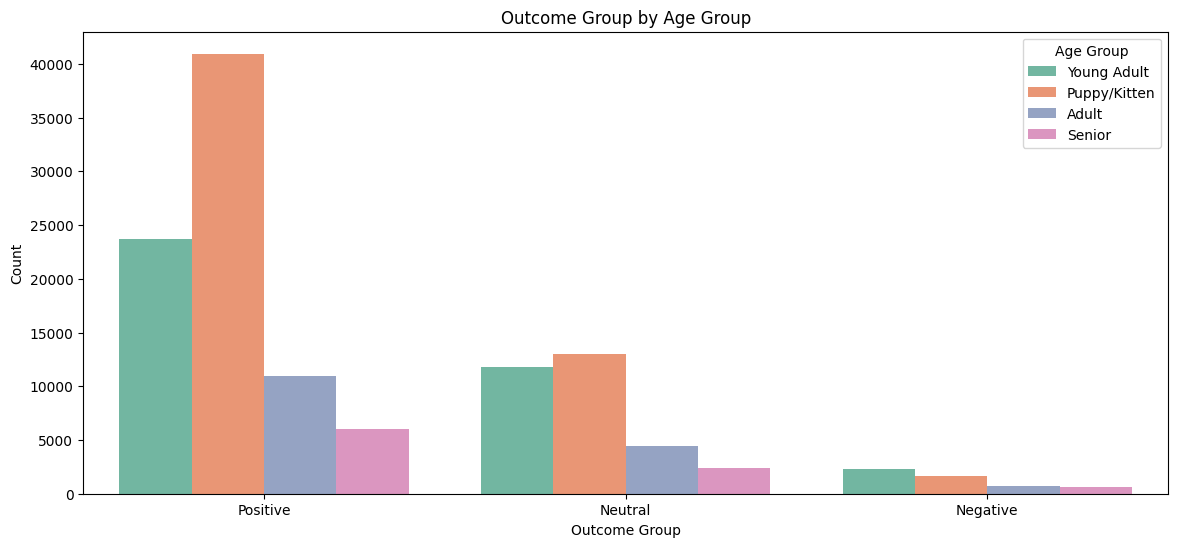

In [20]:
plt.figure(figsize=(14, 6))
sns.countplot(x='outcome_group', hue='age_group_intake', data=animal_df, palette='Set2')
plt.title('Outcome Group by Age Group')
plt.xlabel('Outcome Group')
plt.ylabel('Count')
plt.legend(title='Age Group')
plt.show()


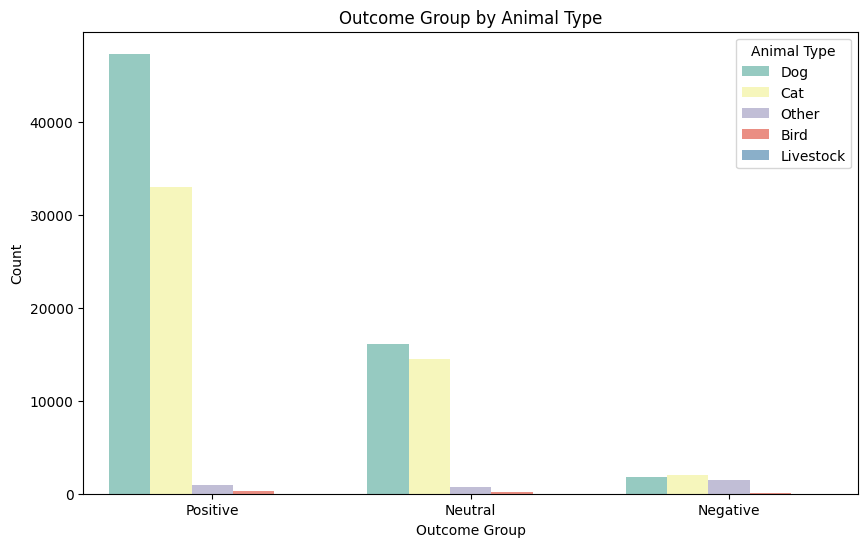

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(x='outcome_group', hue='animal_type', data=animal_df, palette='Set3')
plt.title('Outcome Group by Animal Type')
plt.xlabel('Outcome Group')
plt.ylabel('Count')
plt.legend(title='Animal Type')
plt.show()


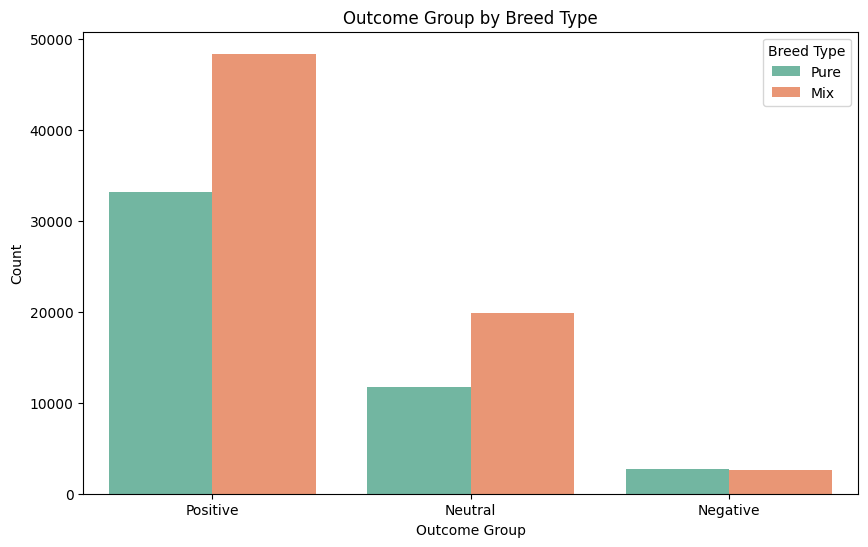

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(x='outcome_group', hue='breed_type', data=animal_df, palette='Set2')
plt.title('Outcome Group by Breed Type')
plt.xlabel('Outcome Group')
plt.ylabel('Count')
plt.legend(title='Breed Type')
plt.show()


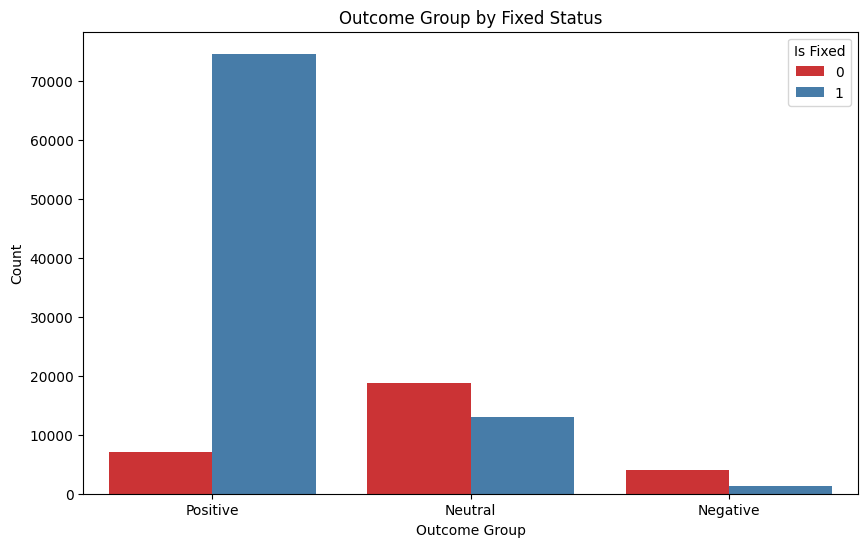

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(x='outcome_group', hue='is_fixed', data=animal_df, palette='Set1')
plt.title('Outcome Group by Fixed Status')
plt.xlabel('Outcome Group')
plt.ylabel('Count')
plt.legend(title='Is Fixed')
plt.show()


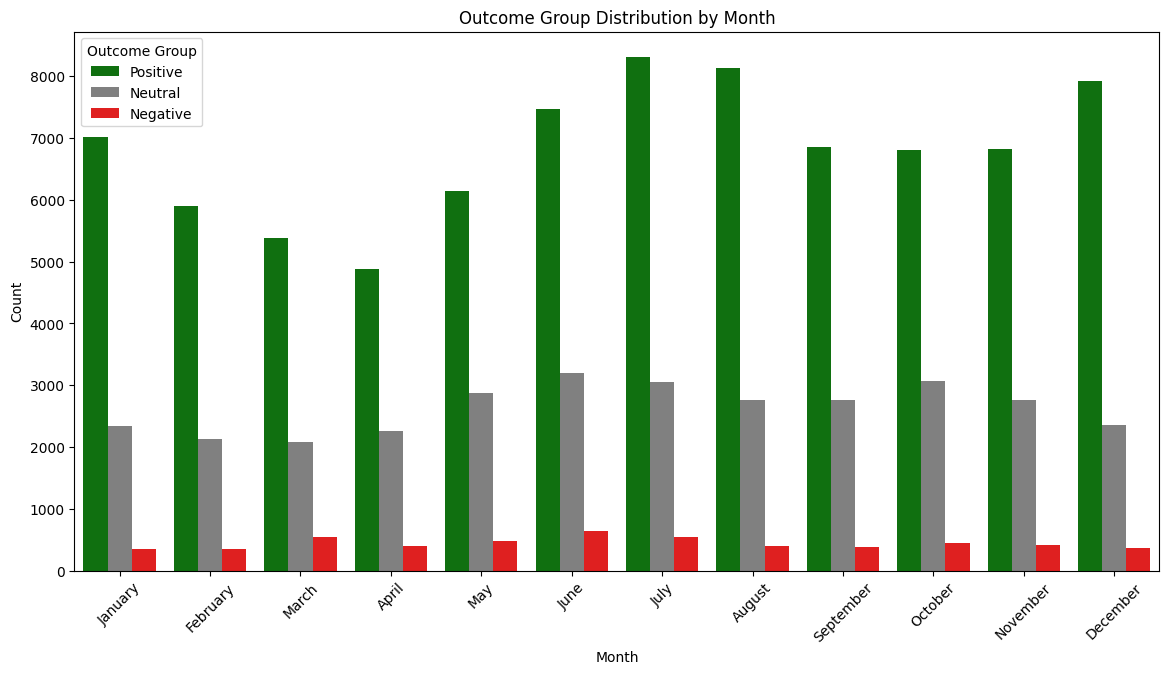

In [25]:
# Define the correct month order
month_order = [
    "January", "February", "March", "April", "May", "June", "July", "August",
    "September", "October", "November", "December"
]

# Ensure `month_of_outcome` is a categorical variable with the correct order
animal_df['month_of_outcome'] = pd.Categorical(animal_df['month_of_outcome'], categories=month_order, ordered=True)

# Define custom colors for outcome groups
custom_palette = {"Positive": "green", "Negative": "red", "Neutral": "gray"}

# Plot Outcome Group by Month with correct ordering and colors
plt.figure(figsize=(14, 7))
sns.countplot(x='month_of_outcome', hue='outcome_group', data=animal_df, palette=custom_palette)

# Customize plot appearance
plt.title('Outcome Group Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Outcome Group')
plt.xticks(rotation=45)

# Show the plot
plt.show()



## SMOTE-ENN Pipeline Since our data set is imbalanced

In [ ]:
# animal_df['outcome_group'].value_counts()

In [ ]:
# !pip install -U imbalanced-learn

In [ ]:
# # Import Libraries
# from imblearn.combine import SMOTEENN
# from imblearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score
# from collections import Counter

In [ ]:
# # Identify Categorical and Numerical Columns
# target = 'outcome_group'  # Target Variable

# # Separate Features and Target
# X = animal_df.drop(columns=[target])
# y = animal_df[target]

# # Identify Column Types
# categorical_cols = X.select_dtypes(include='object').columns.tolist()
# numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

# print("\nCategorical Columns:", categorical_cols)
# print("\nNumerical Columns:", numerical_cols)


In [ ]:
# # Preprocessing for Numerical and Categorical Data
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_cols),      # Scale Numerical Features
#         ('cat', OneHotEncoder(drop='first'), categorical_cols)  # One-Hot Encode Categorical Features
#     ]
# )


In [ ]:
# # Create SMOTEEN and Classifier Pipeline
# smoteen_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('smoteen', SMOTEENN(random_state=42)),
#     ('classifier', RandomForestClassifier(n_jobs=-1, random_state=42))
# ], verbose=True)



In [ ]:
# # Evaluate the Pipeline using Cross-Validation
# scores = cross_val_score(smoteen_pipeline, X, y, cv=3, scoring='f1_macro')
# print("\nCross-Validated F1 Scores:", scores)
# print("\nMean F1 Score:", scores.mean())


In [ ]:
# # Fit the Pipeline to the Entire Dataset
# smoteen_pipeline.fit(X, y)

# # Predictions and Evaluation
# y_pred = smoteen_pipeline.predict(X)

# # Confusion Matrix
# from sklearn.metrics import confusion_matrix, classification_report

# print("\nConfusion Matrix:")
# print(confusion_matrix(y, y_pred))

# print("\nClassification Report:")
# print(classification_report(y, y_pred))


Applying SMOTEEN without scaling

In [ ]:
# # Apply SMOTEEN Directly to the Entire Dataset Without Scaling
# smoteen = SMOTEENN(random_state=42)
# X_resampled, y_resampled = smoteen.fit_resample(X, y)

# # Combine Resampled Features and Target into a DataFrame
# balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
# balanced_df[target] = y_resampled

# print("\nCombined DataFrame After SMOTEEN (No Scaling):")
# print(balanced_df.head())


In [ ]:
# # Verify Class Balance After SMOTEEN on Full Data
# print("\nClass Distribution After SMOTEEN (Full Data):", Counter(y_resampled))


In [ ]:
# # Update animal_df with the Balanced DataFrame
# animal_df = balanced_df.copy()

# print("\nanimal_df Updated with Balanced Data (No Scaling).")

## SMOTEtomek

We used SMOTETomek because it helps balance the classes in our dataset by doing two things:

SMOTE creates new, synthetic examples for the minority classes to make sure they have enough samples, helping the model learn better and avoid bias.
Tomek Links then cleans up the data by removing pairs of samples from different classes that are very close to each other, which usually means they are noisy or overlapping.
By combining these two techniques, SMOTETomek increases the number of minority class samples while also cleaning up confusing data points, giving us a more balanced and cleaner dataset to train our model on.

In [ ]:
# Make a Copy of the Original DataFrame
animal_df_copy = animal_df.copy()

print("\nCopy of animal_df Created.")



Copy of animal_df Created.


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Identify Categorical and Numerical Columns
target = 'outcome_group'  # Target Variable
X_orig = animal_df_copy.drop(columns=[target])
y_orig = animal_df_copy[target]

categorical_cols = X_orig.select_dtypes(include='object').columns.tolist()
numerical_cols = X_orig.select_dtypes(include='number').columns.tolist()

# OneHot Encode Categorical Features
encoder = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # Keep numerical columns as they are
)

# Apply OneHotEncoding to X_orig
X_encoded = encoder.fit_transform(X_orig)

# Get Encoded Feature Names
encoded_feature_names = encoder.get_feature_names_out()

# Create a DataFrame with Encoded Features
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_feature_names)

print("\nOneHotEncoding Completed. Encoded DataFrame:")
print(X_encoded_df.head())



OneHotEncoding Completed. Encoded DataFrame:
   cat__animal_type_Cat  cat__animal_type_Dog  cat__animal_type_Livestock  \
0                   0.0                   1.0                         0.0   
1                   0.0                   1.0                         0.0   
2                   1.0                   0.0                         0.0   
3                   0.0                   0.0                         0.0   
4                   1.0                   0.0                         0.0   

   cat__animal_type_Other  cat__age_group_intake_Puppy/Kitten  \
0                     0.0                                 0.0   
1                     0.0                                 0.0   
2                     0.0                                 1.0   
3                     1.0                                 0.0   
4                     0.0                                 0.0   

   cat__age_group_intake_Senior  cat__age_group_intake_Young Adult  \
0                           0.

In [ ]:
from imblearn.combine import SMOTETomek
from collections import Counter

# Apply SMOTETomek Directly to the Encoded Data
smotetomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smotetomek.fit_resample(X_encoded_df, y_orig)

# Combine Resampled Features and Target into a DataFrame
balanced_df = pd.DataFrame(X_resampled, columns=encoded_feature_names)
balanced_df[target] = y_resampled

print("\nCombined DataFrame After SMOTETomek (Encoded):")
print(balanced_df.head())

# Verify Class Balance After SMOTETomek
print("\nClass Distribution After SMOTETomek:", Counter(y_resampled))



Combined DataFrame After SMOTETomek (Encoded):
   cat__animal_type_Cat  cat__animal_type_Dog  cat__animal_type_Livestock  \
0                   0.0                   1.0                         0.0   
1                   0.0                   1.0                         0.0   
2                   1.0                   0.0                         0.0   
3                   0.0                   0.0                         0.0   
4                   1.0                   0.0                         0.0   

   cat__animal_type_Other  cat__age_group_intake_Puppy/Kitten  \
0                     0.0                                 0.0   
1                     0.0                                 0.0   
2                     0.0                                 1.0   
3                     1.0                                 0.0   
4                     0.0                                 0.0   

   cat__age_group_intake_Senior  cat__age_group_intake_Young Adult  \
0                           

In [ ]:
# Get Index Range for Encoded Categorical Columns
encoded_cat_len = len(X_encoded_df.columns) - len(numerical_cols)

# Extract Encoded Categorical Columns Using .iloc
#X_cat_encoded = X_resampled[:, :encoded_cat_len]  # Original line causing error
X_cat_encoded = X_resampled.iloc[:, :encoded_cat_len] # Use .iloc for DataFrame slicing

# Decode OneHotEncoded Categorical Data
X_decoded = encoder.named_transformers_['cat'].inverse_transform(X_cat_encoded.to_numpy()) # Convert to NumPy array before passing to inverse_transform

# Create DataFrame for Decoded Categorical Data
X_decoded_df = pd.DataFrame(X_decoded, columns=categorical_cols, index=X_resampled.index) # Preserve index

# Extract Numerical Columns Using Explicit Column Names
#X_numerical_df = pd.DataFrame(X_resampled[:, encoded_cat_len:], columns=numerical_cols)  # Original line causing error
X_numerical_df = pd.DataFrame(X_resampled.iloc[:, encoded_cat_len:].to_numpy(), columns=numerical_cols, index=X_resampled.index) # Use .iloc and preserve index

# Combine Decoded Categorical and Numerical Columns Using pd.concat()
X_decoded_full = pd.concat([X_decoded_df, X_numerical_df], axis=1)

# Combine Resampled Features and Target into a DataFrame
balanced_df_orig = X_decoded_full.copy()
balanced_df_orig[target] = y_resampled

print("\nCombined DataFrame After SMOTETomek (Original Format):")
print(balanced_df_orig.head())


Combined DataFrame After SMOTETomek (Original Format):
  animal_type age_group_intake month_of_outcome breed_type color_group  \
0         Dog      Young Adult         February       Pure       Brown   
1         Dog      Young Adult         February        Mix       Black   
2         Cat     Puppy/Kitten         February       Pure         Red   
3       Other      Young Adult         February       Pure       Brown   
4         Cat      Young Adult         February       Pure       Brown   

  intake_condition_group  has_name  age_days_outcome  los_at_shelter  \
0                Injured       0.0             733.0             1.0   
1         Healthy/Normal       1.0             916.0             1.0   
2         Healthy/Normal       1.0             176.0             2.0   
3         Healthy/Normal       0.0             732.0             1.0   
4         Healthy/Normal       1.0             367.0             1.0   

   is_fixed outcome_group  
0       0.0      Positive  
1       0.

In [ ]:
# Verify Class Balance After SMOTETomek on Full Data
print("\nClass Distribution After SMOTETomek (Original Format):", Counter(y_resampled))



Class Distribution After SMOTETomek (Original Format): Counter({'Negative': 80743, 'Neutral': 80171, 'Positive': 79619})


In [ ]:
# Update animal_df with the Balanced DataFrame
animal_df = balanced_df_orig.copy()

print("\nanimal_df Updated with Balanced Data (Original Format).")



animal_df Updated with Balanced Data (Original Format).


In [ ]:
# prompt: df to csv called it SMOTETomek_data

animal_df.to_csv('SMOTETomek_data.csv', index=False)
